In [1]:
import baostock as bs
import pandas as pd
import numpy as np

# 计算日度回报率
def calculate_daily_returns(df):
    df['close'] = df['close'].astype(float)
    df['daily_return'] = df['close'].pct_change()  # 计算日度回报率
    return df

# 获取股票历史数据
def fetch_stock_data(stock_code, start_date, end_date, fields, file_name):
    # 登录
    lg = bs.login()
    if lg.error_code != '0':
        print(f"登录失败，错误代码：{lg.error_code}，错误信息：{lg.error_msg}")
        return None
    
    # 获取历史数据
    rs = bs.query_history_k_data_plus(stock_code,  # 股票代码
                                      fields,  # 需要的字段
                                      start_date=start_date,  # 起始日期
                                      end_date=end_date,  # 结束日期
                                      frequency="d",  # 数据频率：'d'表示日线
                                      adjustflag='3')  # 复权：'3'表示前复权
    
    # 获取数据
    data = []
    while rs.next():
        data.append(rs.get_row_data())
    
    if data:
        df = pd.DataFrame(data, columns=fields.split(','))
        df = calculate_daily_returns(df)
        df.to_csv(file_name, index=False)
        print(f"股票数据已保存到 {file_name}")
    else:
        print("没有获取到数据")
    
    bs.logout()

# 获取市场指数数据（例如：上证指数）
def fetch_market_data(market_code, start_date, end_date, fields, file_name):
    lg = bs.login()
    if lg.error_code != '0':
        print(f"登录失败，错误代码：{lg.error_code}，错误信息：{lg.error_msg}")
        return None
    
    # 获取市场指数数据
    rs = bs.query_history_k_data_plus(market_code,  # 市场指数代码
                                      fields,  # 需要的字段
                                      start_date=start_date,  # 起始日期
                                      end_date=end_date,  # 结束日期
                                      frequency="d",  # 数据频率：'d'表示日线
                                      adjustflag='3')  # 复权：'3'表示前复权
    
    # 获取数据
    data = []
    while rs.next():
        data.append(rs.get_row_data())
    
    if data:
        df = pd.DataFrame(data, columns=fields.split(','))
        df = calculate_daily_returns(df)
        df.to_csv(file_name, index=False)
        print(f"市场数据已保存到 {file_name}")
    else:
        print("没有获取到市场数据")
    
    bs.logout()


# 数据集准备

## 函数库

In [2]:
import plotly.express as px
start='2023-12-01'
end='2024-11-30'
def Interplolate(df,time,order=2):
    df.loc[:,time]=pd.to_datetime(df[time])
    df.set_index(time,inplace=True)
    date_range = pd.date_range(start=start, end=end, freq='D')
    df = df[start:end].reindex(date_range)
    if np.isnan(df.iloc[0].item()):
        df.iloc[0]=df.mean().item()
    return df,df.interpolate(method='spline',order=order)

def BfAfInterplolate(df,df_filled):
    fig = px.line(x=df.index, y=df[df.columns[0]], line_shape='linear', title="Yield over Time")

    fig.add_scatter(x=df_filled.index, y=df_filled[df_filled.columns[0]], mode='lines', name="Interpolated Data", line=dict(color='red'))
    var=np.var(df_filled.to_numpy())
    mean=np.mean(df_filled.to_numpy())
    fig.update_traces(connectgaps=False)
    fig.update_layout(
        title="Yield over Time",
        xaxis_title="Date",
        yaxis_title="Yield(%)",
        legend_title="Data",
        legend=dict(
            title="Legend",
            x=1,
            y=1
        )
    )
   
    fig.add_annotation(
        x=df_filled.index[len(df_filled)//2],  # 放置注释的x位置
        y=max(df_filled[df_filled.columns[0]]),  # 放置注释的y位置
        text=f"Variance: {var:.4f}Mean: {mean:.4f}",  # 方差值，保留四位小数
        showarrow=False,  # 不显示箭头
        font=dict(size=12, color='black'),  # 设置字体大小和颜色
        bgcolor='white'  # 背景颜色
    )
 
    fig.show()

def CalYield(Clsprc):
    e=Clsprc.to_numpy()
    e_filled = np.zeros(e.shape[0] + 1) 
    e_filled[1:]=e
    e_filled[0]=2*e[0]-e[1]
    Yield=np.log(e_filled[1:]/e_filled[:-1])*100
    return Yield
    
def StkProcessing(df,time,code,columns):
    df=df[df['Filling']==0]
    df_dict={}
    for column in columns:
        col_df = df[df[code].notnull()][[time,code, column]]
        col_df = col_df.pivot(index=time, columns=code, values=column)
        df_dict[column] = col_df

    return df_dict


## 数据清洗

In [3]:
import pandas as pd
import numpy as np
Market=pd.read_csv('TRD_Cndalym.csv')
Amarket=Market[Market['Markettype']==5]
Amarket.loc[:,'Cdretmdos'] = Amarket['Cdretmdos'] * 100
marketflow=Amarket[['Trddt','Cdretmdos']]

lowrisk=pd.read_csv('BND_TreasYield.csv')
lowrisk=lowrisk[lowrisk['Cvtype']==2]
lowrisk_1y=lowrisk[lowrisk['Yeartomatu']==1][['Trddt','Yield']]
lowrisk_1y.loc[:,'Yield']=lowrisk_1y['Yield'].astype(np.float64)/365
lowrisk_1y,lowrisk_1y_filled=Interplolate(lowrisk_1y,'Trddt')

marketflow,marketflow_filled=Interplolate(marketflow,'Trddt',1)
filled_datalist=[marketflow_filled,lowrisk_1y_filled]
datalist=[marketflow,lowrisk_1y]



In [4]:
time='TradingDate'
code='Symbol'
dfs = [pd.read_csv(f'TRD_FwardQuotation{i}.csv') for i in range(1, 7)]
combined_df = pd.concat(dfs)
columns=['OpenPrice','ClosePrice','TurnoverRate1','MarketValue','CirculatedMarketValue']
stkdf_dict=StkProcessing(combined_df,time,code,columns)


## 数据集划分

In [5]:
# #spilt
# def split(datalist, a=0.8):
#     train_datas = []
#     test_datas = []
    
#     for df in datalist:
#         # 获取数据的分割点
#         train_size = int(len(df) * a)  # 计算训练集的大小
        
#         # 切割数据集
#         train_data = df.iloc[:train_size]  # 前 a% 的数据作为训练集
#         test_data = df.iloc[train_size:]  # 剩余的数据作为测试集
        
#         # 添加到对应的列表
#         train_datas.append(train_data)
#         test_datas.append(test_data)
    
#     return train_datas, test_datas
# train_datas,test_datas=split(filled_datalist)
# org_train,org_test=split(datalist)


## 收益率曲线展示

In [6]:
# for df,filled_df,test_df,filled_test_df in zip(org_train,train_datas,org_test,test_datas):
#     BfAfInterplolate(df,filled_df)
#     BfAfInterplolate(test_df,filled_test_df)

# 收益率溢价评估

## CAPM

In [7]:
# stk_index=np.arange(len(train_datas))[2:]
# def CalBetas(datalist,market_index,stk_index):
#     betas=[]
#     for i in stk_index:
#         cov=np.cov(datalist[i].to_numpy().flatten(),datalist[market_index].to_numpy().flatten())
#         betai=cov[0,1]/cov[1,1]
#         betas.append(betai)
#     return betas

# def CalERi(datalist,betas,market_index,lowrisk_index,episilon=0):
#     m=np.array(datalist)[market_index].squeeze(1)
#     l=np.array(datalist)[lowrisk_index].squeeze(1)
#     delta=m-l
#     return np.array(betas).reshape(-1,1)@delta.reshape(1,-1)+l

# def GetCovMatrix(datalist,stk_index):
#     return np.cov(np.array(datalist)[stk_index].squeeze(2),rowvar=True)

# betas=CalBetas(train_datas,0,stk_index)
# ERi=CalERi(train_datas,betas,0,1)
# CovMatrix=GetCovMatrix(train_datas,stk_index)



## 资产组合优化

## numpy解析法

In [8]:
# def minimize_sigma(sigma,u,u_star):
#     '''np方法得到给定收益率期望下使得风险系数最小的权重向量解析解'''
#     one=np.zeros((u.shape[0],1))+1
#     inv_sigma=np.linalg.inv(sigma)
#     A=np.concatenate((one.T,u.T))
#     P1=one.T@inv_sigma@A.T
#     P2=u.T@inv_sigma@A.T
#     P=np.concatenate((P1,P2))
#     b=np.matrix([1,u_star]).reshape(2,1)
#     lambdas=np.linalg.solve(P,b)
#     return lambdas.T@A@inv_sigma

# u=ERi[:,100].reshape(ERi.shape[0],1)
# w=minimize_sigma(CovMatrix,u,1)

# U=w@u
# var=w@CovMatrix@w.T

# print(w)
# print(U/np.sqrt(var))

## cvxpy凸优化库二次规划

In [9]:
# import cvxpy as cp
# def cp_minimize_sigma(CovMatrix,u,ustar):
#     w=cp.Variable(u.shape[0])

#     objective=cp.Minimize(cp.quad_form(w,CovMatrix))

#     constrains=[cp.sum(w)==1,w>=0,w@u>=ustar]

#     problem=cp.Problem(objective,constrains)
#     problem.solve()
#     if problem.status not in ["infeasible", "unbounded"]:
#         return w.value,cp.quad_form(w,CovMatrix).value
#     else:
#         raise ValueError("minimize Optimization did not succeed. Status: " + problem.status)
# def cp_maximize_u(CovMatrix,u,sig):
#     w=cp.Variable(u.shape[0])

#     objective=cp.Maximize(w@u)

#     constrains=[cp.sum(w)==1,w>=0,cp.quad_form(w,CovMatrix)<=sig]

#     problem=cp.Problem(objective,constrains)
#     problem.solve()
#     if problem.status not in ["infeasible", "unbounded"]:
#         return w.value,cp.quad_form(w,CovMatrix).value
#     else:
#         raise ValueError("maximize Optimization did not succeed. Status: " + problem.status)
# ustar=0.08
# sig=1.2
# w1,s1=cp_maximize_u(CovMatrix,u,sig)
# w2,s2=cp_minimize_sigma(CovMatrix,u,ustar)

# print(w1@u/np.sqrt(s1),w1@u,s1)
# print(w2@u/np.sqrt(s2),w2@u,s2)


# 回测

## 回测类

In [37]:
class Backtest:
    def __init__(self,OpenPrc,stock_data,StartDay,initial_cash=100000):
        self.Oprc=OpenPrc
        self.startday=StartDay
        self.stock_data = stock_data
        self.initial_cash = initial_cash
        self.cash = initial_cash
        self.positions = pd.Series(0, index=range(len(stock_data.columns)))
        self.name=stock_data.columns  
        self.history = []  # 记录每个时间步的账户状态

    def set_strategy(self,BS,SS):
        self.BS=BS
        self.SS=SS

    def run(self):
        self.day=0
        for self.date, row in self.Oprc.loc[self.startday:].iterrows():
            self.prices=row.to_numpy()
            self._sell(self.SS(self.stock_data.loc[:self.date]))
            self._buy(self.BS(self.stock_data.loc[:self.date]))
            self.history.append({
                'date': self.date,
                'cash': self.cash,
                'positions': self.positions.copy(),
                'portfolio_value': self.cash + (self.positions * self.prices).sum()
            })
            self.day+=1
    
    def _buy(self, buy_signals):
        for idx, qty in buy_signals.items():
            if qty*self.prices[idx]<self.cash:
                self.cash -= qty*self.prices[idx]
                self.positions.iloc[idx] += qty

    def _sell(self, sell_signals):
        for idx, qty in sell_signals.items():
            self.cash -= qty*self.prices[idx]
            self.positions.iloc[idx] += qty

  



## 函数库

### 组合优化

In [11]:
import torch
import cvxpy as cp
def cp_minimize_sigma(CovMatrix,u,ustar):
    w=cp.Variable(u.shape[0])

    objective=cp.Minimize(cp.quad_form(w,CovMatrix))

    constrains=[cp.sum(w)==1,w>=0,w@u>=ustar]

    problem=cp.Problem(objective,constrains)
    problem.solve()
    if problem.status not in ["infeasible", "unbounded"]:
        return w.value,cp.quad_form(w,CovMatrix).value
    else:
        raise ValueError("minimize Optimization did not succeed. Status: " + problem.status)
def cp_maximize_u(CovMatrix,u,sig):
    w=cp.Variable(u.shape[0])

    objective=cp.Maximize(w@u)

    constrains=[cp.sum(w)==1,w>=0,cp.quad_form(w,CovMatrix)<=sig]

    problem=cp.Problem(objective,constrains)
    problem.solve()
    if problem.status not in ["infeasible", "unbounded"]:
        return w.value,cp.quad_form(w,CovMatrix).value
    else:
        raise ValueError("maximize Optimization did not succeed. Status: " + problem.status)
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def SelectStks(df,ustar=0):
    m=torch.tensor(df.fillna(df.mean()).to_numpy())
    m[torch.isnan(m)]=-1
    m=m.to(device)
    Yield=torch.log(m[1:,:]/m[:-1,:])*100#(%)
    var=torch.var(Yield,dim=0,unbiased=True)

    U=Yield.mean(0)

    info=U/(torch.sqrt(var)+(var==0).float())

    _,indices=torch.topk(info,30)
    filtered_idxs=indices[U[indices]>ustar]

    return filtered_idxs.cpu(),Yield.cpu()

def Estimate(Yield,idxs):
    cov=torch.cov(Yield[:,idxs].to(device).T)
    u=Yield[:,idxs].mean(0)
    return cov.cpu(),u.cpu()


## 策略类

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
class Strategy:
    def __init__(self,dflist,startday,initial_money=100000):
        self.backtest=Backtest(dflist[0],dflist[1],startday
                              ,initial_money)
    def buy_strategy():
        raise NotImplementedError("Subclasses should implement this method.")
    def sell_strategy():
        raise NotImplementedError("Subclasses should implement this method.")
    def run(self):
        self.backtest.run()
    def show(self):
        # Plot portfolio value
        sns.lineplot(pd.DataFrame(self.backtest.history)['portfolio_value'])

        # Calculate maximum drawdown
        portfolio_values = pd.DataFrame(self.backtest.history)['portfolio_value']
        running_max = portfolio_values.cummax()  # cumulative maximum value
        drawdown = (portfolio_values - running_max) / running_max  # drawdown from running max
        max_drawdown = drawdown.min()  # maximum drawdown value

        # Show maximum drawdown on the plot
        plt.title(f"Portfolio Value - Max Drawdown: {max_drawdown:.2%}")
        plt.show()
            


class MyStrategy(Strategy):
    def __init__(self, dflist, startday,sig, initial_money=100000):
        super().__init__(dflist, startday, initial_money)
        self.backtest.set_strategy(self.buy_strategy,self.sell_strategy)
        self.sig=sig
    def Refresh_Position(self,Clprc):
        Oprc=self.backtest.prices
        idxs,Yield=SelectStks(Clprc.iloc[:-1])
        if self.backtest.day==0:
            position_idxs=idxs
        else:
            hist_position=self.backtest.positions
            histidxs=torch.tensor(hist_position[hist_position>0].index,dtype=torch.int32)
            position_idxs=torch.concatenate((histidxs,idxs)).unique()
        cov,u=Estimate(Yield,position_idxs)
        p_idxs=position_idxs.cpu().numpy()
        w,sig=cp_maximize_u(cov,u,self.sig)

        now_position=self.backtest.positions.to_numpy()

        total_cash=self.backtest.cash+now_position[p_idxs]@Oprc[p_idxs]
        
        k=total_cash/(Oprc[p_idxs]@w)
        W=np.floor(w*k)

        changes=W-now_position[p_idxs]
      
        return changes,p_idxs
    
 
    

    def buy_strategy(self,Clprc):
        buy_signals = {}
        if self.backtest.day%30==0:
            changes,position_idxs=self.Refresh_Position(Clprc)
            for idx,qty in zip(position_idxs,changes):
                if qty>0:
                    buy_signals[idx]=qty

        return buy_signals


    def sell_strategy(self,Clprc):
        sell_signals = {}
        if self.backtest.day%30==0:
            changes,position_idxs=self.Refresh_Position(Clprc)
            for idx,qty in zip(position_idxs,changes):
                if qty<0:
                    sell_signals[idx]=qty
        else:
            now_position=self.backtest.positions
            now_idxs=now_position.index[now_position>0]
            for idx,prices in zip(now_idxs,self.backtest.prices[now_idxs]):
                if prices>Clprc.iloc[:,idx].mean()+Clprc.iloc[:,idx].std():
                    sell_signals[idx]=-now_position[idx]
        return sell_signals

In [ ]:
startday='2023-12-01'
sig=1.5
backtesting = MyStrategy([stkdf_dict[columns[0]],stkdf_dict[columns[1]]],startday,sig)
backtesting.run()
backtesting.show()



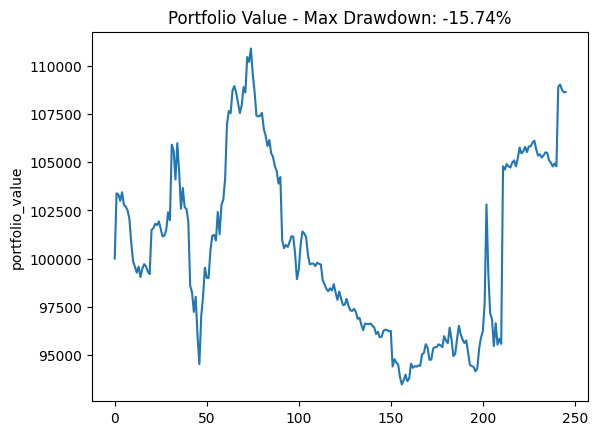

In [61]:
import matplotlib.pyplot as plt
def show(hist):
    # Plot portfolio value
    sns.lineplot(pd.DataFrame(hist)['portfolio_value'])

    # Calculate maximum drawdown
    portfolio_values = pd.DataFrame(hist)['portfolio_value']
    running_max = portfolio_values.cummax()  # cumulative maximum value
    drawdown = (portfolio_values - running_max) / running_max  # drawdown from running max
    max_drawdown = drawdown.min()  # maximum drawdown value

    # Show maximum drawdown on the plot
    plt.title(f"Portfolio Value - Max Drawdown: {max_drawdown:.2%}")
    plt.show()
hist=backtesting.backtest.history
show(hist)

In [ ]:
df=backtesting.backtest.positions
print()

TypeError: cannot unpack non-iterable int object